In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from scipy.special import softmax
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [2]:
iris = pd.read_csv('Iris.csv')
iris = iris.drop(['Id'], axis=1)
iris_dataset = iris.drop(['Species'],  axis=1)
iris_target = iris['Species']

In [3]:
iris_target.value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

In [108]:
iris_dataset.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
dtype: int64

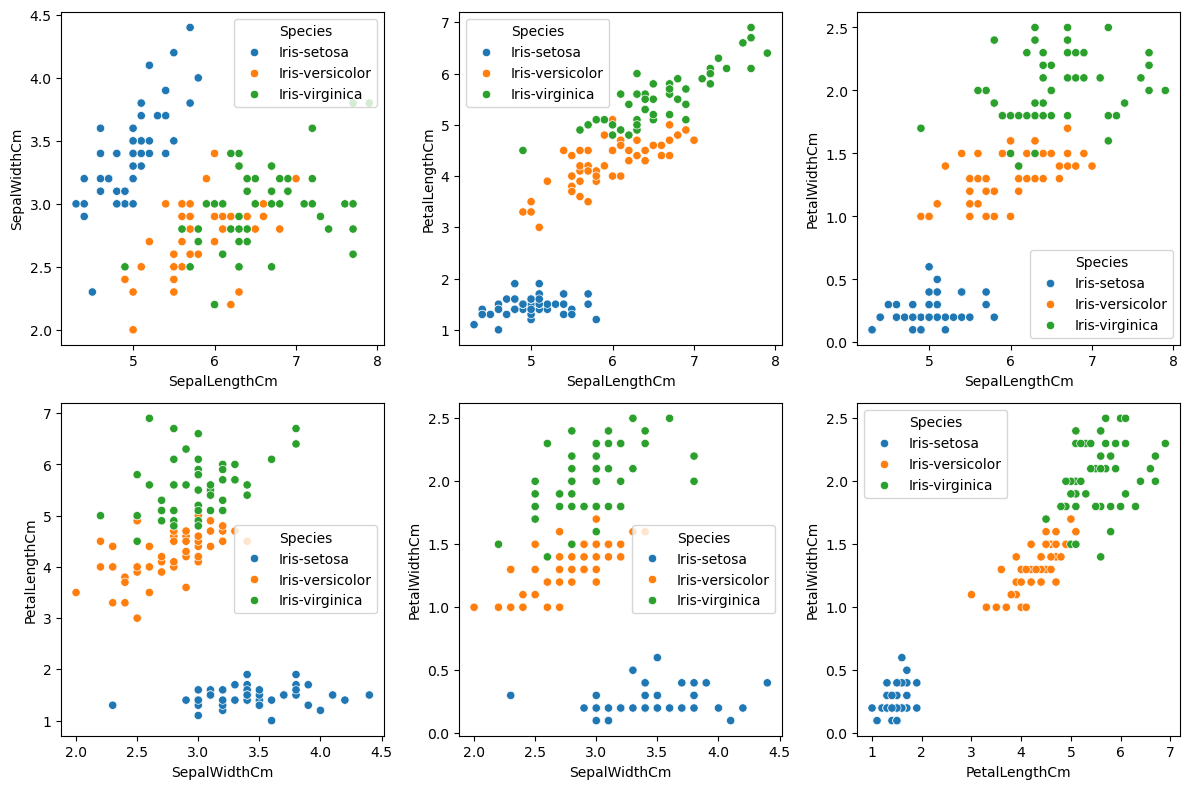

In [109]:
features = iris_dataset.columns

plt.figure(figsize=(12,8))
k = 1
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.subplot(2, 3, k)
        sns.scatterplot(x=features[i], y=features[j], data=iris, hue="Species")
        k += 1
        
plt.tight_layout() 
plt.show()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(iris_dataset, iris_target, 
                                                   test_size=0.3, random_state=18)

##### Шкалирование числовых данных:

In [5]:
np.unique(y_train)

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [4]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [112]:
print(f'Разброс значений в обучающей выборке: от {np.min(x_train)} до {np.max(x_train)}')
print(f'Разброс значений в тестовой выборке: от {np.min(x_test)} до {np.max(x_test)}')

Разброс значений в обучающей выборке: от -2.386471607492792 до 3.090676344130012
Разброс значений в тестовой выборке: от -1.9300426115242246 до 2.634247348161445


## Линейная регрессия:

In [15]:
models = []

#создаем модель для определения каждого вида из Species (1 против всех):
for species in iris_target.unique():
    y_binary = (y_train==species).astype(int)
    linear_reg = LinearRegression()
    linear_reg.fit(x_train, y_binary)
    models.append(linear_reg)

In [16]:
#создаем массив [элементы тестовой выбоки х модели]
predict = np.zeros((x_test.shape[0], len(models)))

#строим предсказание по каждой из созданных моделей
for i, model in enumerate(models):
    predict[:, i] = model.predict(x_test)

In [115]:
predict[:5]

array([[ 0.19203995,  0.69126024,  0.11669981],
       [ 0.17395701,  0.57717775,  0.24886524],
       [ 0.15753136,  0.67318831,  0.16928033],
       [ 0.99351971,  0.08790772, -0.08142743],
       [ 0.82337848,  0.34099219, -0.16437067]])

In [17]:
probabilities = softmax(predict, axis=1)

In [117]:
probabilities[:5]

array([[0.2797309 , 0.46083883, 0.25943027],
       [0.27976548, 0.41870742, 0.3015271 ],
       [0.27125584, 0.45428256, 0.27446161],
       [0.57286559, 0.23160634, 0.19552807],
       [0.50258263, 0.31024856, 0.18716881]])

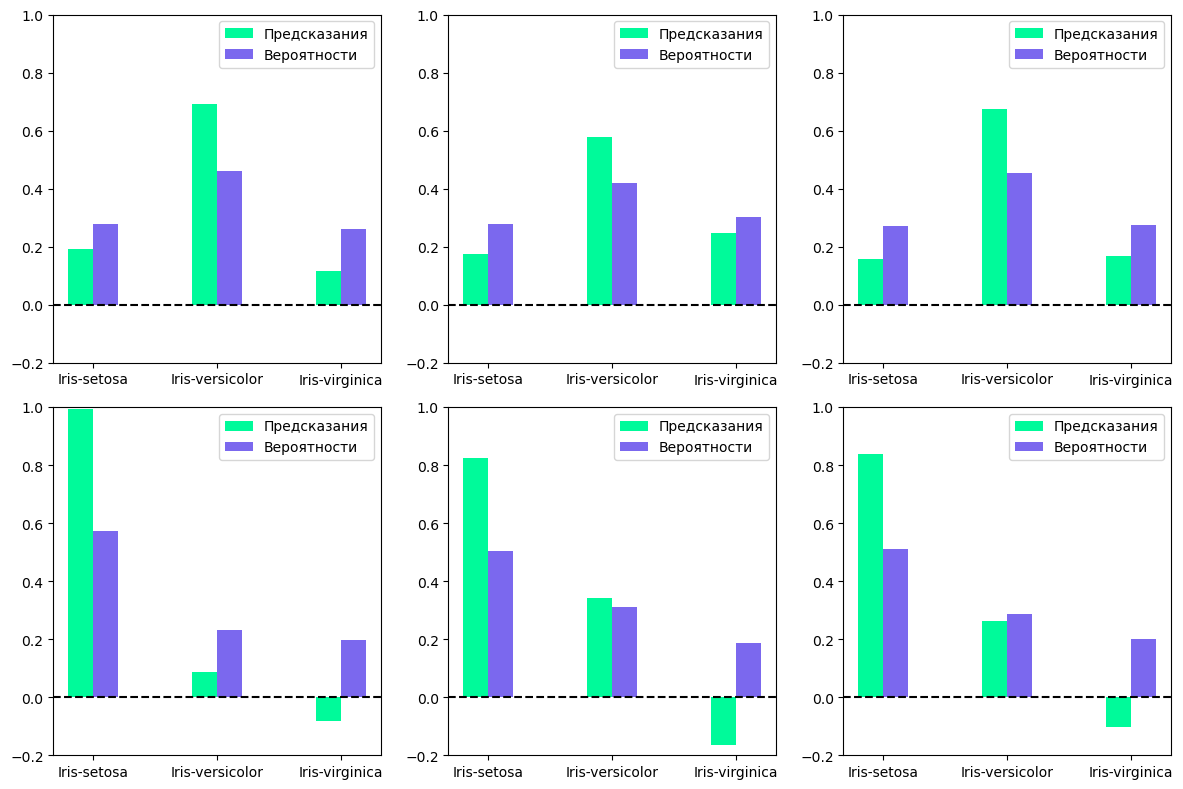

In [18]:
delta = 0.2
cat = iris_target.unique()
x = np.arange(len(cat))

plt.figure(figsize=(12,8))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.bar(x, predict[i-1], width=0.2, color='#00FA9A', label='Предсказания')
    plt.bar(x+delta, probabilities[i-1], width=0.2, color='#7B68EE', label='Вероятности')
    plt.xticks(x+delta/2, labels=cat)
    plt.ylim(-0.2, 1)
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    
    
plt.tight_layout() 
plt.show()

In [119]:
max_predict = np.argmax(probabilities, axis=1)
linear_predict = iris_target.unique()[max_predict]

In [120]:
linear_predict[:5]

array(['Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

In [121]:
print(classification_report(y_test, linear_predict))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.92      0.85      0.88        13
 Iris-virginica       0.89      0.94      0.91        17

       accuracy                           0.93        45
      macro avg       0.94      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45



In [6]:
def metrics(method, y_test, y_pred):
    print(f'{method}. Метрики для классификации:\n')
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3}')
    print(f'Precision:  {precision_score(y_test, y_pred, average="macro"):.3}')
    print(f'Recall:  {recall_score(y_test, y_pred, average="macro"):.3}')
    #macro - Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [194]:
metrics("Линейная регрессия", y_test, linear_predict)

Линейная регрессия. Метрики для классификации:

Accuracy:  0.933
Precision:  0.935
Recall:  0.929


In [123]:
print(f"MSE:{mean_squared_error(y_test.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), max_predict)}")

MSE:0.06666666666666667


In [205]:
def plot_confusion_matrix(method, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='flare', xticklabels=iris_target.unique(), yticklabels=iris_target.unique())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{method} confusion Matrix")
    plt.show()

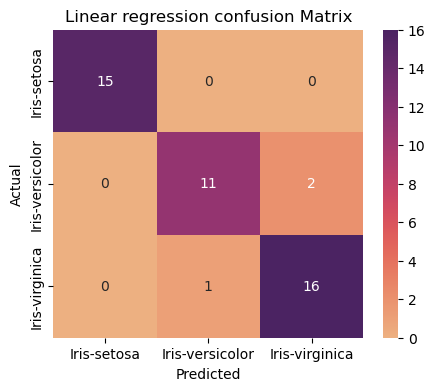

In [206]:
plot_confusion_matrix("Linear regression", y_test, linear_predict)

In [125]:
print(iris_dataset.columns)
print(models[0].coef_)
print(models[1].coef_)
print(models[2].coef_)

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')
[ 0.06305377  0.10315427 -0.32846826 -0.11617354]
[-0.02679719 -0.1866683   0.29590861 -0.25660874]
[-0.03625658  0.08351403  0.03255965  0.37278228]


## Логистическая регрессия

In [126]:
logistic_reg = LogisticRegression(multi_class='ovr')
logistic_reg.fit(x_train, y_train)
y_pred_logistic = logistic_reg.predict(x_test)

print(classification_report(y_test, y_pred_logistic))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.94      1.00      0.97        17

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.98        45
   weighted avg       0.98      0.98      0.98        45



In [195]:
metrics("Логистическая регрессия", y_test, y_pred_logistic)

Логистическая регрессия. Метрики для классификации:

Accuracy:  0.978
Precision:  0.981
Recall:  0.974


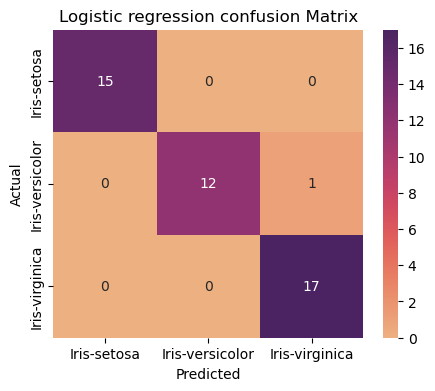

In [208]:
plot_confusion_matrix("Logistic regression", y_test, y_pred_logistic)

## SVM

#### Linear kernel

In [7]:
svm_clf_lin = SVC(kernel='linear', decision_function_shape='ovr')
svm_clf_lin.fit(x_train, y_train)
svm_pred_lin = svm_clf_lin.predict(x_test)

print(classification_report(y_test, svm_pred_lin))
metrics("SVM linear kernel", y_test, svm_pred_lin)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        17

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45

SVM linear kernel. Метрики для классификации:

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


#### Radial Basis Function kernel

In [8]:
svm_clf_rbf = SVC(kernel='rbf', decision_function_shape='ovr')
svm_clf_rbf.fit(x_train, y_train)
svm_pred_rbf = svm_clf_rbf.predict(x_test)

print(classification_report(y_test, svm_pred_rbf))
metrics("SVM rbf kernel", y_test, svm_pred_rbf)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        17

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45

SVM rbf kernel. Метрики для классификации:

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


#### Polynomial kernel

In [9]:
svm_clf_poly = SVC(kernel='poly', decision_function_shape='ovr')
svm_clf_poly.fit(x_train, y_train)
svm_pred_poly = svm_clf_poly.predict(x_test)

print(classification_report(y_test, svm_pred_poly))
metrics("SVM poly kernel", y_test, svm_pred_poly)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.93      1.00      0.96        13
 Iris-virginica       1.00      0.94      0.97        17

       accuracy                           0.98        45
      macro avg       0.98      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45

SVM poly kernel. Метрики для классификации:

Accuracy:  0.978
Precision:  0.976
Recall:  0.98


In [12]:
# отрисовка границы решений

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

def svm_plot(kernel):
    svm_2d = SVC(kernel=kernel)
    plt.figure(figsize=(12, 8))
    k = 1
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            plt.subplot(2, 3, k)
            k += 1

            x_train_subset = x_train[:, [i, j]]
            x_test_subset = x_test[:, [i, j]]
            svm_2d.fit(x_train_subset, y_train_encoded)

            for class_value in le.classes_:
                plt.scatter(
                    x_test_subset[y_test == class_value, 0],
                    x_test_subset[y_test == class_value, 1],
                    label=f'Test {class_value}',
                    alpha=0.7
                )

            plt.xlabel(f"{features[i]}")
            plt.ylabel(f"{features[j]}")

            # Создание сетки для отображения границы принятия решения
            x_min, x_max = x_test_subset[:, 0].min() - 0.5, x_test_subset[:, 0].max() + 0.5
            y_min, y_max = x_test_subset[:, 1].min() - 0.5, x_test_subset[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))

            # Предсказание на сетке
            Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            # Отрисовка контуров
            plt.contourf(xx, yy, Z, alpha=0.15,  levels=[-1, 0, 1, 2], colors=['blue', 'orange', 'green'])

    plt.legend()
    plt.suptitle(f"SVC {kernel} kernel: test set", fontsize=16)
    plt.tight_layout()
    plt.show()

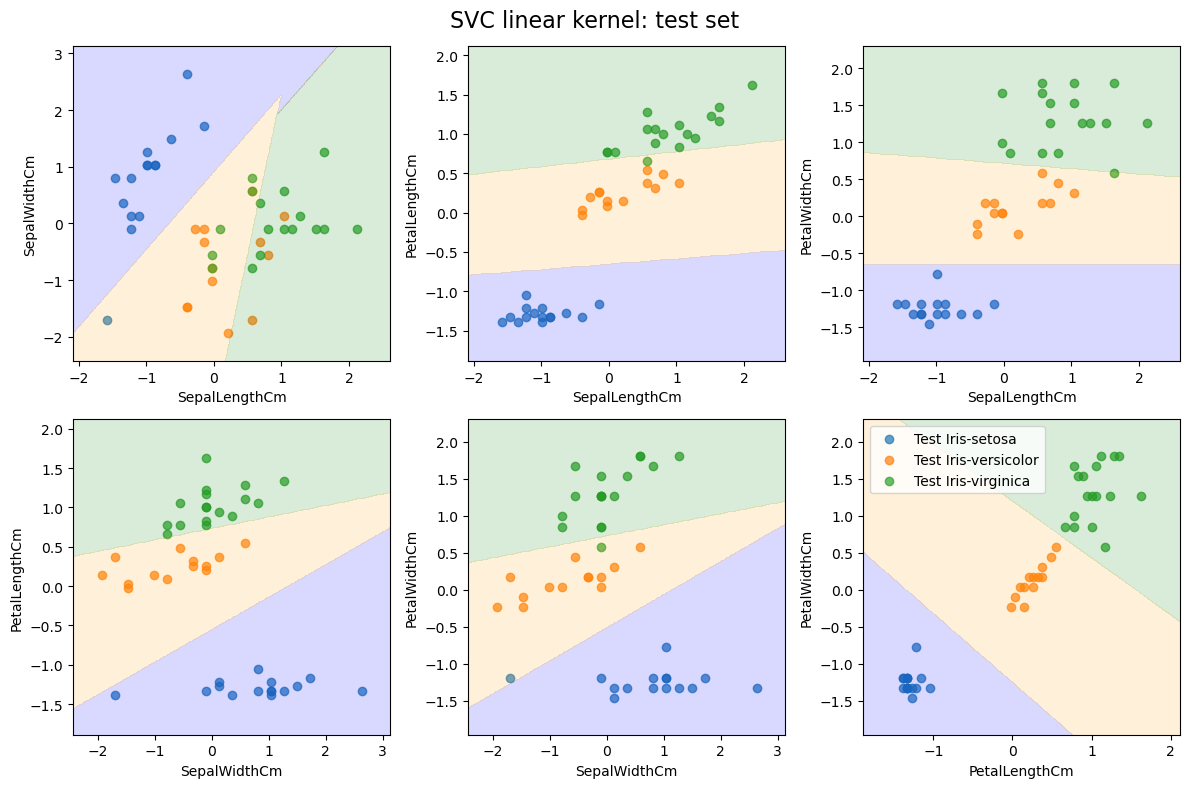

In [220]:
svm_plot('linear')

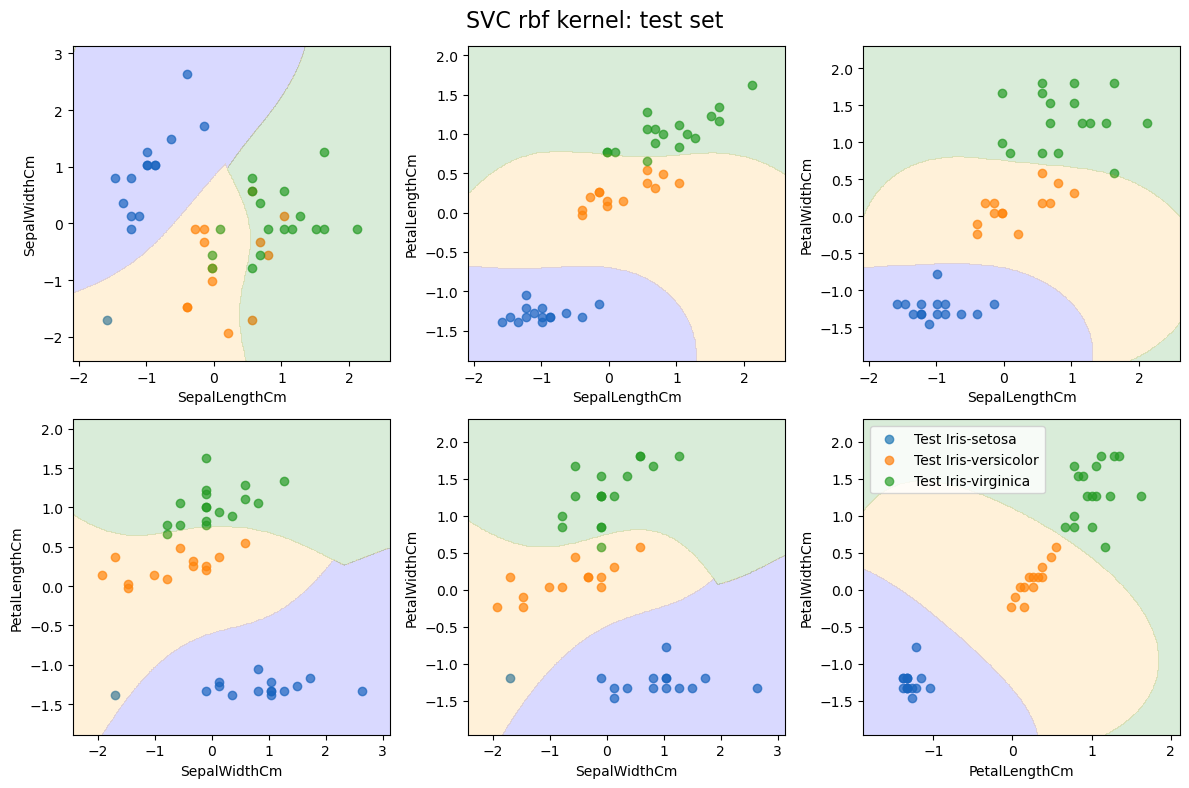

In [221]:
svm_plot('rbf')

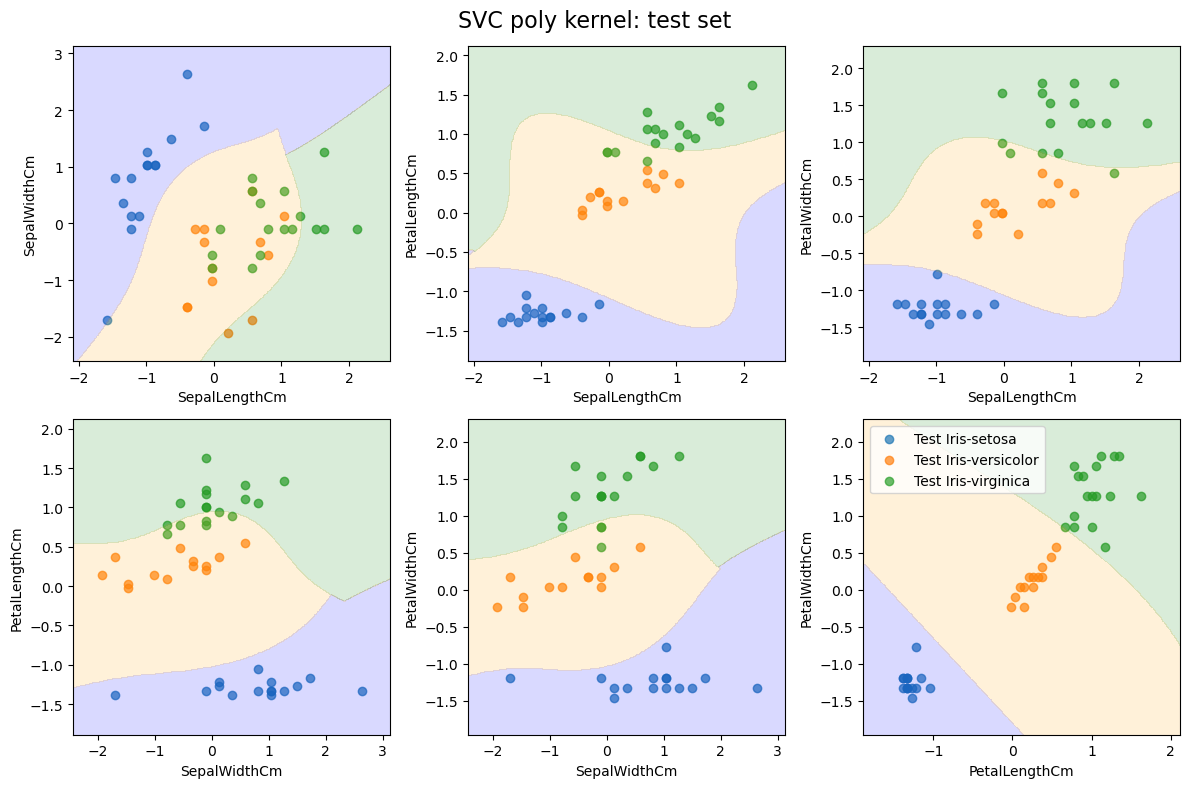

In [222]:
svm_plot('poly')

In [28]:
def svm_plot_pca(kernel):

    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(x_train)
    X_test_2d = pca.fit_transform(x_test)

    model = SVC(kernel=kernel)
    model.fit(X_train_2d, y_train_encoded)

    y_pred = model.predict(X_test_2d)

    plt.figure(figsize=(6, 4))

    for class_value in cat:
        plt.scatter(
            X_test_2d[y_test == class_value, 0],  # Первый главный компонент
            X_test_2d[y_test == class_value, 1],  # Второй главный компонент
            label=f'{class_value}',
            alpha=0.7
        )

    # Создание сетки для отображения границы принятия решения
    x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
    y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Прогноз классов для каждого элемента сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Отображение границы принятия решения
    plt.contourf(xx, yy, Z, alpha=0.2, levels=[-1, 0, 1, 2], colors=['blue', 'orange', 'green'])

    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Граница принятия решения SVC")
    plt.legend()
    plt.show()

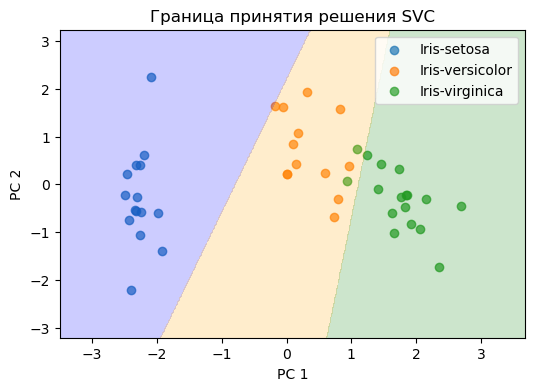

In [29]:
svm_plot_pca('linear')

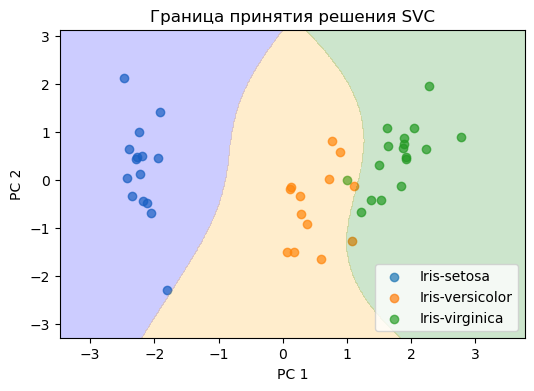

In [20]:
svm_plot_pca('rbf')

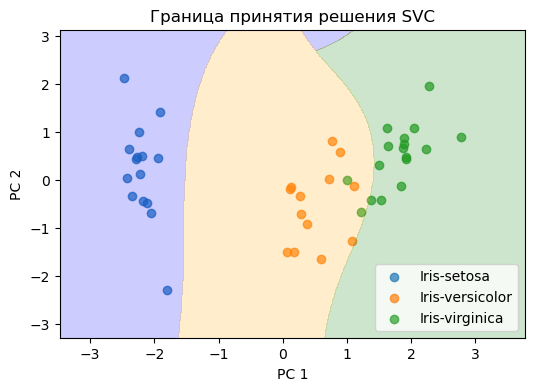

In [21]:
svm_plot_pca('poly')